In [111]:
import pandas as pd
import numpy as np
# from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport
import datetime
import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go
from plotly.subplots import make_subplots
%matplotlib inline
import seaborn as sns
sns.set()
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from joblib import dump, load
from prophet.serialize import model_to_json, model_from_json
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from mlforecast import MLForecast
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
import logging
#logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt

## Les fonctions à utiliser 

### draw_ts_multiple

In [69]:
def draw_ts_multiple(df: pd.DataFrame, v1: str, v2: str=None, prediction: str=None, date: str='date',
              secondary_y=True, covid_zone=False, display=True):
  """Draw times series possibly on two y axis, with COVID period option.

  Args:
  - df (pd.DataFrame): time series dataframe (one line per date, series in columns)
  - v1 (str | list[str]): name or list of names of the series to plot on the first x axis
  - v2 (str): name of the serie to plot on the second y axis (default: None)
  - prediction (str): name of v1 hat (prediction) displayed with a dotted line (default: None)
  - date (str): name of date column for time (default: 'date')
  - secondary_y (bool): use a secondary y axis if v2 is used (default: True)
  - covid_zone (bool): highlight COVID-19 period with a grayed rectangle (default: False)
  - display (bool): display figure otherwise just return the figure (default: True)

  Returns:
  - fig (plotly.graph_objs._figure.Figure): Plotly figure generated

  Notes:
  Make sure to use the semi-colon trick if you don't want to have the figure displayed twice.
  Or use `display=False`.
  """
  if isinstance(v1, str):
    variables = [(v1, 'V1')]
  else:
    variables = [(v, 'V1.{}'.format(i)) for i, v in enumerate(v1)]
  title = '<br>'.join([n + ': '+ v for v, n in variables]) + ('<br>V2: ' + v2) if v2 else '<br>'.join([v + ': '+ n for v, n in variables])
  layout = dict(
    title=title,
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
  )
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.update_layout(layout)
  for v, name in variables:
    fig.add_trace(go.Scatter(x=df[date], y=df[v], name=name), secondary_y=False)
  if v2:
    fig.add_trace(go.Scatter(x=df[date], y=df[v2], name='V2'), secondary_y=secondary_y)
    fig['layout']['yaxis2']['showgrid'] = False
    fig.update_yaxes(rangemode='tozero')
    fig.update_layout(margin=dict(t=125 + 30 * (len(variables) - 1)))
  if prediction:
    fig.add_trace(go.Scatter(x=df[date], y=df[prediction], name='^V1', line={'dash': 'dot'}), secondary_y=False)

  if covid_zone:
    fig.add_vrect(
        x0=pd.Timestamp("2020-03-01"), x1=pd.Timestamp("2022-01-01"),
        fillcolor="Gray", opacity=0.5,
        layer="below", line_width=0,
    )
  if display:
    pyoff.iplot(fig)
  return fig

### generate_route_df

In [70]:
def generate_route_df(traffic_df: pd.DataFrame, homeAirport:str, paireAirport: str) -> pd.DataFrame:
    

    # """
    # Extract route datafrae from traffic dataframe for route from home airport to paired airport 
    # Args:
    # -traffic_df (pd.DataFrame): traffic datafram
    # - homeAirport (str): IAIA code from airport
    # - pairedAirport (str): IAIA coe for paired airpport
    # Return
    # """

    _df=(traffic_df
        .query ('home_airport == "{}" and paired_airport =="{}"'.format(homeAirport, paireAirport))
        .groupby(['home_airport', 'paired_airport', 'date'])
        .agg(pax_total=('pax', 'sum'))
        .reset_index() 
        )
    return _df

## Importer des données 

In [3]:
traffic_df = pd.read_parquet("/Users/lilyhuong/Desktop/Amse mag3/semestre 2/Forecast air traffic/airtraffic/traffic_10lines.parquet")

In [4]:
traffic_df.shape

(254899, 21)

## Descritive statistics 

### Par utiliser describe()

In [49]:
traffic_df.describe(include = 'all', datetime_is_numeric=True).transpose()

count unique        top    freq  \
date                  254899    NaN        NaN     NaN   
pax                 254899.0    NaN        NaN     NaN   
seats               250749.0    NaN        NaN     NaN   
flight_type           251168     19          J  240627   
flight_typename       254899      4  Scheduled  251250   
home_airport          254899      8        LIS  125254   
paired_airport        254899     10        OPO   72331   
home_airportname      254899      8     Lisbon  125254   
paired_airportname    254899     10      Porto   72331   
distance            254899.0   <NA>       <NA>    <NA>   
flight_number         251438   2663     TP 433    2332   
airline_iata          248648     90         TP   91648   
airline_name          254813    131        TAP   91648   
scheduled_datetime    254899    NaN        NaN     NaN   
direction             254899      2          D  127622   
home_country          254899      7         PT  125254   
paired_country        254899      8         PT   72331   
home_countryname      254899      7   Portugal  125254   
paired_countryname    254899      8   Portugal   72331   
travel_area           254899      4   Domestic  108770   
aircraft_type         251439    168       A320   30344   

                                             mean                  min  \
date                2019-04-14 00:20:15.163653120  2016-01-01 00:00:00   
pax                                    127.082676                -11.0   
seats                                  159.352879                  0.0   
flight_type                                   NaN                  NaN   
flight_typename                               NaN                  NaN   
home_airport                                  NaN                  NaN   
paired_airport                                NaN                  NaN   
home_airportname                              NaN                  NaN   
paired_airportname                            NaN                  NaN   
distance                               944.365078                277.0   
flight_number                                 NaN                  NaN   
airline_iata                                  NaN                  NaN   
airline_name                                  NaN                  NaN   
scheduled_datetime  2019-04-14 14:11:44.273065472  2016-01-01 06:10:00   
direction                                     NaN                  NaN   
home_country                                  NaN                  NaN   
paired_country                                NaN                  NaN   
home_countryname                              NaN                  NaN   
paired_countryname                            NaN                  NaN   
travel_area                                   NaN                  NaN   
aircraft_type                                 NaN                  NaN   

                                    25%                  50%  \
date                2017-07-31 00:00:00  2019-02-07 00:00:00   
pax                                88.0                140.0   
seats                             144.0                174.0   
flight_type                         NaN                  NaN   
flight_typename                     NaN                  NaN   
home_airport                        NaN                  NaN   
paired_airport                      NaN                  NaN   
home_airportname                    NaN                  NaN   
paired_airportname                  NaN                  NaN   
distance                          277.0               1109.0   
flight_number                       NaN                  NaN   
airline_iata                        NaN                  NaN   
airline_name                        NaN                  NaN   
scheduled_datetime  2017-07-31 06:55:00  2019-02-07 08:05:00   
direction                           NaN                  NaN   
home_country                        NaN                  NaN   
paired_country               

### Par utiliser ProfileReport()

In [67]:
profile_report = ProfileReport(traffic_df)
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [62]:
# Enregistrer profilereport to html
profile_report.to_file("Analysis.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# get the sum of total passsenger between home airport and pair airport
(traffic_df
.groupby(["home_airport", "paired_airport"])
.agg(date_min = ("date", "min"), date_max = ("date", "max"), pax = ("pax", "sum"))
.reset_index()
)

home_airport paired_airport   date_min   date_max        pax
0          LGW            AMS 2016-01-01 2023-03-09  5372822.0
1          LGW            BCN 2016-01-01 2023-03-10  7613076.0
2          LIS            OPO 2016-01-01 2023-03-09  5632745.0
3          LIS            ORY 2016-01-01 2023-03-09  7696068.0
4          LYS            PIS 2017-11-20 2023-03-09    10351.0
5          NTE            FUE 2019-01-06 2023-03-05    99854.0
6          PNH            NGB 2016-05-05 2023-03-07    10018.0
7          POP            JFK 2018-01-01 2023-03-09   492434.0
8          SCL            LHR 2019-01-01 2023-03-07   193693.0
9          SSA            GRU 2019-01-01 2023-03-09  5272186.0

In [11]:
#get the airline name with home airport and pair arport is NTE and FUE with minimum of 100 passengers 
(traffic_df
.query('home_airport == "NTE" and paired_airport == "FUE" and pax >= 100')
["airline_name"]
.value_counts()
)

Volotea                339
Smartwings             116
Transavia               90
Enter Air               77
ASL Airlines France      1
Name: airline_name, dtype: int64

In [12]:
(traffic_df
.query('home_airport == "NTE" and paired_airport == "FUE"')
["airline_name"]
.value_counts()
)

Volotea                362
Smartwings             140
Transavia               98
Enter Air               81
ASL Airlines France      1
Ryanair                  1
Name: airline_name, dtype: int64

### Plot le nombre total de passengers par jour entre NTE et FUE 

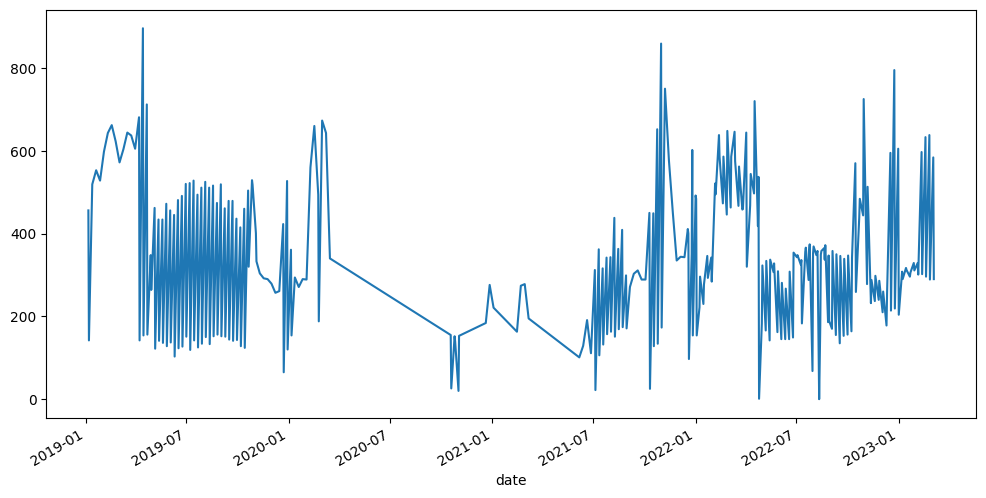

In [14]:

(traffic_df
.query('home_airport == "NTE" and paired_airport == "FUE"')
.groupby(["home_airport", "paired_airport", "date"])
.agg(pax_total = ("pax", "sum"))
.reset_index()
.set_index("date")
["pax_total"]
.plot(figsize= (12, 6))
);

In [65]:
# traffic_df.query('home_airport == "NTE" and paired_airport == "FUE"').groupby(["home_airport", "paired_airport", "date"]).agg(pax_total = ("pax", "sum")).reset_index().set_index("date")["pax_total"].plot(figsize= (12, 6))


### Plot le nombre total de passengers par jour entre LGW et AMS

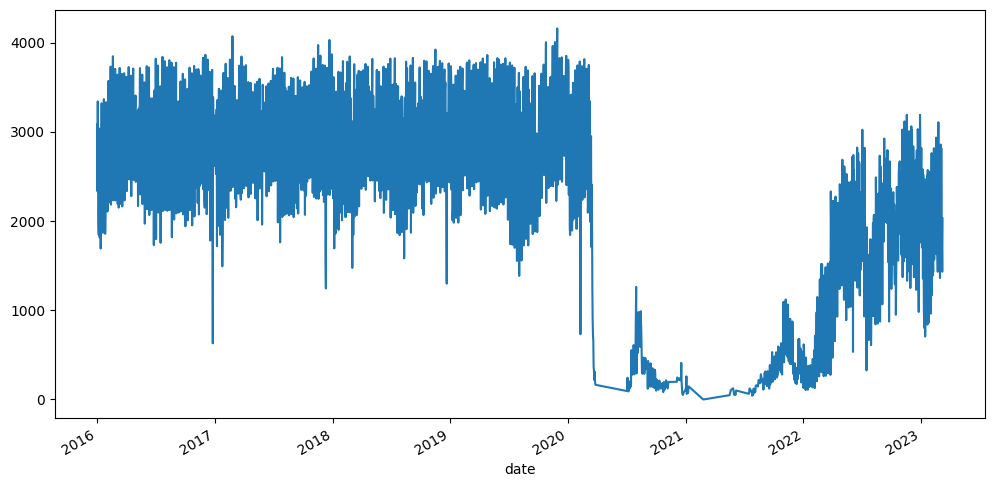

In [16]:

(traffic_df
.query('home_airport == "LGW" and paired_airport == "AMS"')
.groupby(["home_airport", "paired_airport", "date"])
.agg(pax_total = ("pax", "sum"))
.reset_index()
.set_index("date")
["pax_total"]
.plot(figsize= (12, 6))
);

In [66]:
# (traffic_df
# .query('home_airport == "LGW" and paired_airport == "AMS"')
# .groupby(["home_airport", "paired_airport", "date"])
# .agg(pax_total = ("pax", "sum"))
# .reset_index()
# .set_index("date")
# ["pax_total"]
# .plot(figsize= (12, 6))
# );

### plotly

#### Sans zone covid 

In [20]:
draw_ts_multiple(
    (traffic_df
    .query('home_airport == "LGW" and paired_airport == "AMS"')
    .groupby(["home_airport", "paired_airport", "date"])
    .agg(pax_total = ("pax", "sum"))
    .reset_index()
    ),
    'pax_total'
)

#### Avec la zone covid

In [21]:
draw_ts_multiple(
    (traffic_df
    .query('home_airport == "LGW" and paired_airport == "AMS"')
    .groupby(["home_airport", "paired_airport", "date"])
    .agg(pax_total = ("pax", "sum"))
    .reset_index()
    ),
    'pax_total',
    covid_zone = True,
)

## Prévision de trafic aérien 

In [115]:
nte_fue_df = (traffic_df
 .query ('home_airport == "NTE" and paired_airport =="FUE"')
 .groupby(['home_airport', 'paired_airport', 'date'])
 .agg(pax_total=('pax', 'sum'))
 .reset_index() 
 )
nte_fue_df

home_airport paired_airport       date  pax_total
0            NTE            FUE 2019-01-06      456.0
1            NTE            FUE 2019-01-07      142.0
2            NTE            FUE 2019-01-13      519.0
3            NTE            FUE 2019-01-20      553.0
4            NTE            FUE 2019-01-27      528.0
..           ...            ...        ...        ...
288          NTE            FUE 2023-02-19      296.0
289          NTE            FUE 2023-02-25      638.0
290          NTE            FUE 2023-02-26      289.0
291          NTE            FUE 2023-03-04      584.0
292          NTE            FUE 2023-03-05      290.0

[293 rows x 4 columns]

In [72]:
lgw_ams_df=(traffic_df
 .query ('home_airport == "LGW" and paired_airport == "AMS"')
 .groupby(['home_airport', 'paired_airport', 'date'])
 .agg(pax_total=('pax', 'sum'))
 .reset_index() 
 )
lgw_ams_df

home_airport paired_airport       date  pax_total
0             LGW            AMS 2016-01-01     3081.0
1             LGW            AMS 2016-01-02     2334.0
2             LGW            AMS 2016-01-03     3341.0
3             LGW            AMS 2016-01-04     2665.0
4             LGW            AMS 2016-01-05     1996.0
...           ...            ...        ...        ...
2243          LGW            AMS 2023-03-05     2815.0
2244          LGW            AMS 2023-03-06     1916.0
2245          LGW            AMS 2023-03-07     1741.0
2246          LGW            AMS 2023-03-08     1432.0
2247          LGW            AMS 2023-03-09     2029.0

[2248 rows x 4 columns]

### Prophet

#### First training with prophet

In [107]:
# test générer the dataset for NTE and FUE airport 
generate_route_df(traffic_df, 'NTE', "FUE")

home_airport paired_airport       date  pax_total
0            NTE            FUE 2019-01-06      456.0
1            NTE            FUE 2019-01-07      142.0
2            NTE            FUE 2019-01-13      519.0
3            NTE            FUE 2019-01-20      553.0
4            NTE            FUE 2019-01-27      528.0
..           ...            ...        ...        ...
288          NTE            FUE 2023-02-19      296.0
289          NTE            FUE 2023-02-25      638.0
290          NTE            FUE 2023-02-26      289.0
291          NTE            FUE 2023-03-04      584.0
292          NTE            FUE 2023-03-05      290.0

[293 rows x 4 columns]

In [105]:
# First model apply to NTE FUE 
baseline_model = Prophet()
baseline_model.fit(generate_route_df(traffic_df, 'NTE', "FUE").rename(columns = {'date':'ds', 'pax_total':'y'}))

In [106]:
#prepare prediction for next 15 days 
future_df = baseline_model.make_future_dataframe(periods=15) 
future_df

ds
0   2019-01-06
1   2019-01-07
2   2019-01-13
3   2019-01-20
4   2019-01-27
..         ...
303 2023-03-16
304 2023-03-17
305 2023-03-18
306 2023-03-19
307 2023-03-20

[308 rows x 1 columns]

In [108]:
forecast_df = baseline_model.predict(future_df)

In [109]:
forecast_df 

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2019-01-06  341.079424  292.992756  595.403585   341.079424   341.079424   
1   2019-01-07  340.949434   39.972445  340.916825   340.949434   340.949434   
2   2019-01-13  340.169493  245.445803  546.627427   340.169493   340.169493   
3   2019-01-20  339.259561  246.405359  542.746949   339.259561   339.259561   
4   2019-01-27  338.349630  301.792669  610.967049   338.349630   338.349630   
..         ...         ...         ...         ...          ...          ...   
303 2023-03-16  237.709910  -75.817849  231.492696   237.709910   237.709910   
304 2023-03-17  237.696720  273.114394  573.544891   237.696720   237.696720   
305 2023-03-18  237.683530  310.499711  621.084915   237.683530   237.683530   
306 2023-03-19  237.670340  341.784169  646.093228   237.670340   237.671153   
307 2023-03-20  237.657150   97.123671  408.352915   237.656207   237.658549   

     additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0        108.941493            108.941493            108.941493  132.840302   
1       -150.871118           -150.871118           -150.871118 -118.253191   
2         56.073219             56.073219             56.073219  132.840302   
3         51.009210             51.009210             51.009210  132.840302   
4        104.532296            104.532296            104.532296  132.840302   
..              ...                   ...                   ...         ...   
303     -163.904126           -163.904126           -163.904126 -288.799795   
304      183.184223            183.184223            183.184223   57.304080   
305      229.103327            229.103327            229.103327  102.300391   
306      260.524969            260.524969            260.524969  132.840302   
307       10.297225             10.297225             10.297225 -118.253191   

     weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0      132.840302    132.840302  -23.898808    -23.898808    -23.898808   
1     -118.253191   -118.253191  -32.617927    -32.617927    -32.617927   
2      132.840302    132.840302  -76.767083    -76.767083    -76.767083   
3      132.840302    132.840302  -81.831091    -81.831091    -81.831091   
4      132.840302    132.840302  -28.308006    -28.308006    -28.308006   
..            ...           ...         ...           ...           ...   
303   -288.799795   -288.799795  124.895669    124.895669    124.895669   
304     57.304080     57.304080  125.880143    125.880143    125.880143   
305    102.300391    102.300391  126.802936    126.802936    126.802936   
306    132.840302    132.840302  127.684667    127.684667    127.684667   
307   -118.253191   -118.253191  128.550417    128.550417    128.550417   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
303                   0.0                         0.0   
304                   0.0                         0.0   
305                   0.0                         0.0   
306                   0.0                         0.0   
307                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
0                           0.0  450.020917  
1                           0.0  190.078316  
2                           0.0  396.242712  
3                           0.0  390.268772  
4                           0.0  442.881925  
..                          ...         ...  
303                         0.0   73.805784  
304                         0.0  420.880943  
305                         0.0  466.786857  
306                         0.0  498.195309  
307       

In [110]:
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


ds        yhat  yhat_lower  yhat_upper
0   2019-01-06  450.020917  292.992756  595.403585
1   2019-01-07  190.078316   39.972445  340.916825
2   2019-01-13  396.242712  245.445803  546.627427
3   2019-01-20  390.268772  246.405359  542.746949
4   2019-01-27  442.881925  301.792669  610.967049
..         ...         ...         ...         ...
303 2023-03-16   73.805784  -75.817849  231.492696
304 2023-03-17  420.880943  273.114394  573.544891
305 2023-03-18  466.786857  310.499711  621.084915
306 2023-03-19  498.195309  341.784169  646.093228
307 2023-03-20  247.954375   97.123671  408.352915

[308 rows x 4 columns]

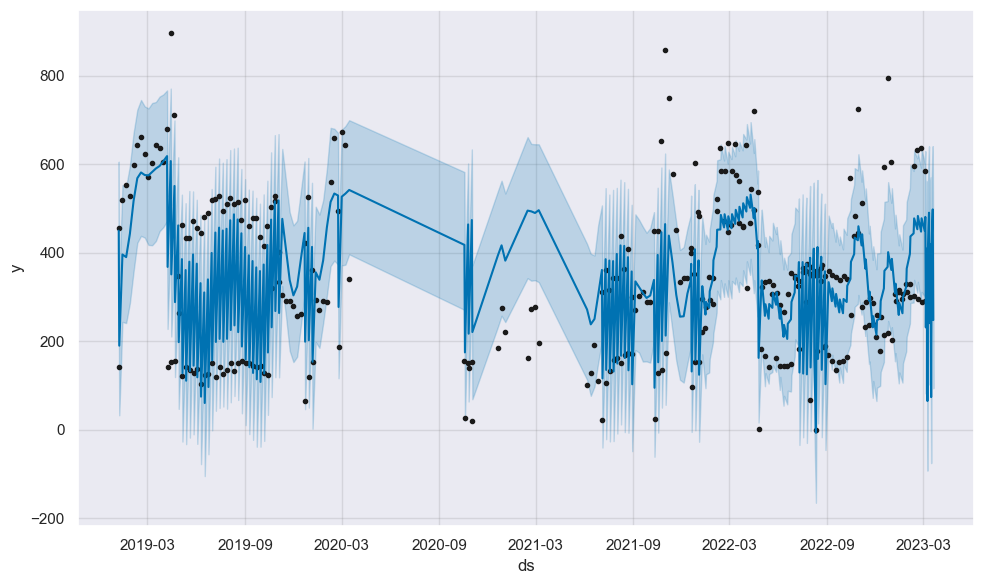

In [82]:
baseline_model.plot(forecast_df);
# graph = baseline_model.plot(forecast_df);

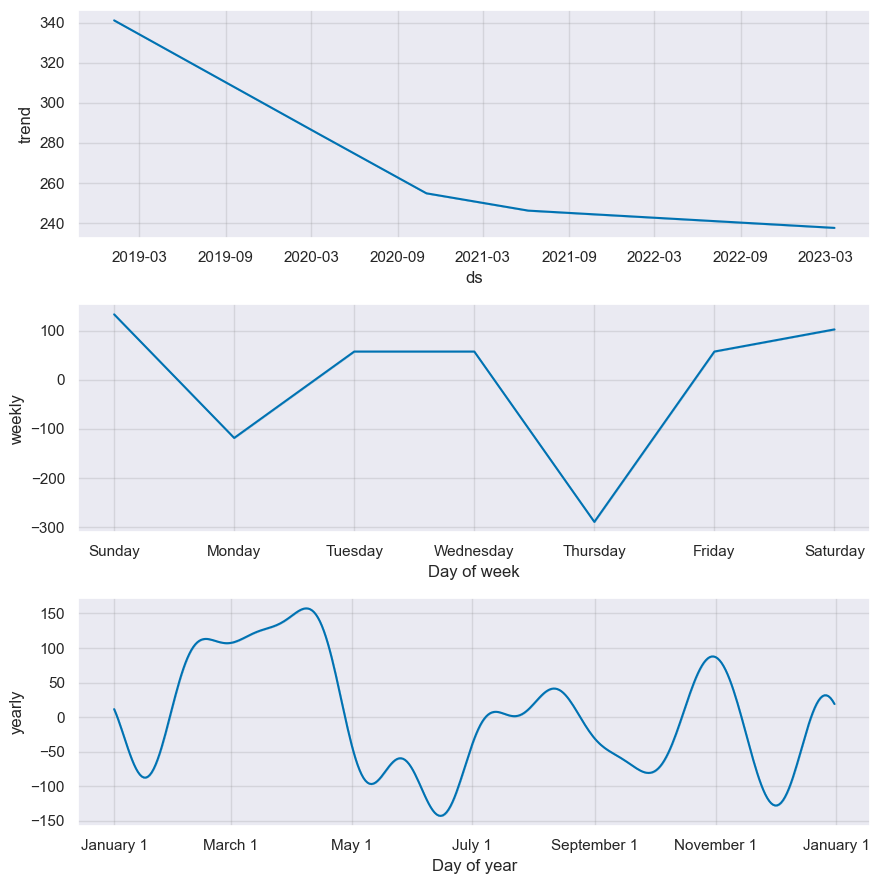

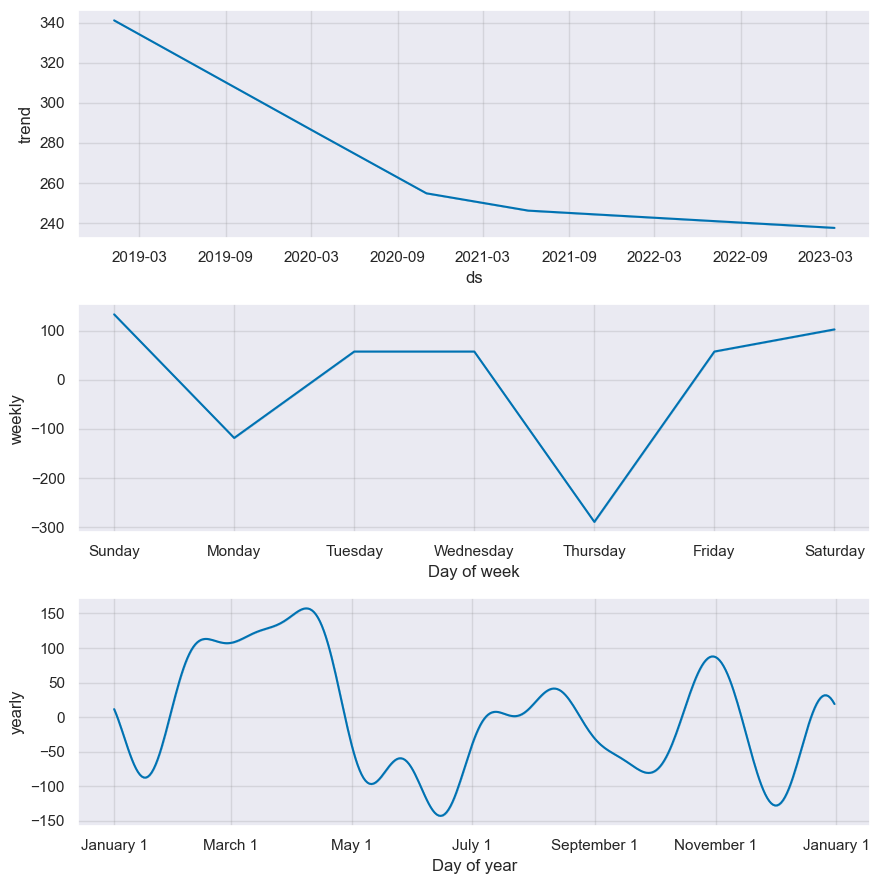

In [83]:
baseline_model.plot_components(forecast_df)

In [89]:
# Here we do cross-validation to assess prediction performance on a horizon of 90 days, 
# starting with 366 days of training data in the first cutoff and then making predictions every 90 days 

######### More simple:
#(the initial model will be trained on the first 366 days of data and forecast for next 90 days).
# second time, The model will then train on the initial period + the period (366 + 90 days in this case (because period = 90)) and forecast the next 90 days.
# It will continued like this, adding another 90 days to the training data and then forecasting for the next 90 until there is no longer enough data to do this.

###### On this 5 year time series, this corresponds to 10 total forecasts.

eval_df = cross_validation(baseline_model, initial='366 days', period = '90 days' , horizon= '90 days')
eval_df

  0%|          | 0/10 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper      y     cutoff
0   2020-10-18  447.472952  351.556864  536.482821  155.0 2020-09-16
1   2020-10-19  124.280990   32.712143  217.789203   26.0 2020-09-16
2   2020-10-25  488.585274  394.455784  579.514942  152.0 2020-09-16
3   2020-10-26  153.801841   63.407351  236.732158  139.0 2020-09-16
4   2020-11-01  439.584883  342.421600  530.699624   20.0 2020-09-16
..         ...         ...         ...         ...    ...        ...
189 2023-02-19  572.425628  429.556085  706.247889  296.0 2022-12-05
190 2023-02-25  473.095078  333.660674  611.329550  638.0 2022-12-05
191 2023-02-26  563.164621  423.091816  702.424609  289.0 2022-12-05
192 2023-03-04  472.997567  331.903234  616.747242  584.0 2022-12-05
193 2023-03-05  564.970905  441.905456  701.029376  290.0 2022-12-05

[194 rows x 6 columns]

In [44]:
performance_metrics(eval_df)

horizon           mse        rmse         mae     mdape     smape  coverage
0  10 days   7796.945228   88.300313   71.582558  0.174532  0.280109  0.736842
1  11 days   9130.910680   95.555799   76.752375  0.227063  0.312874  0.710526
2  12 days  12259.557503  110.722886   84.793053  0.196479  0.321302  0.684211
3  13 days  13562.038871  116.456167   89.758648  0.229652  0.332409  0.657895
4  14 days  12780.066346  113.048956   85.028606  0.196479  0.317877  0.684211
..     ...           ...         ...         ...       ...       ...       ...
76 86 days  34455.742517  185.622581  151.383274  0.566790  0.608887  0.508772
77 87 days  30103.956444  173.504918  147.431686  0.497560  0.547031  0.473684
78 88 days  27329.734354  165.317072  138.193187  0.438342  0.517581  0.526316
79 89 days  23969.507333  154.820888  127.486324  0.330678  0.480108  0.631579
80 90 days  27552.125377  165.988329  138.245243  0.497560  0.569379  0.526316

[81 rows x 7 columns]

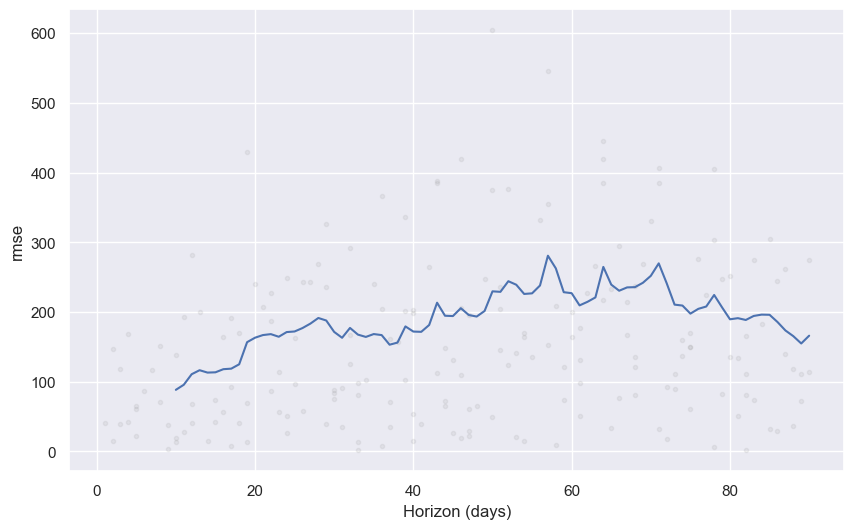

In [46]:
plot_cross_validation_metric(eval_df, metric = 'rmse');

#### Improve the forecasting performance avec prophet


Dans la résultat d'évaluation de performance de la prédiction, on a vu notre modèle prophet a mal prédire le nombre de passagers en 2020, 2021.

En effet, le nombre de passagers en réalité est beaucoup plus petite que par rapport que notre prédiction, 

on peut expliquer ce résultat par la périod covid qui a fait une chute fortement de nombre de passengers. 

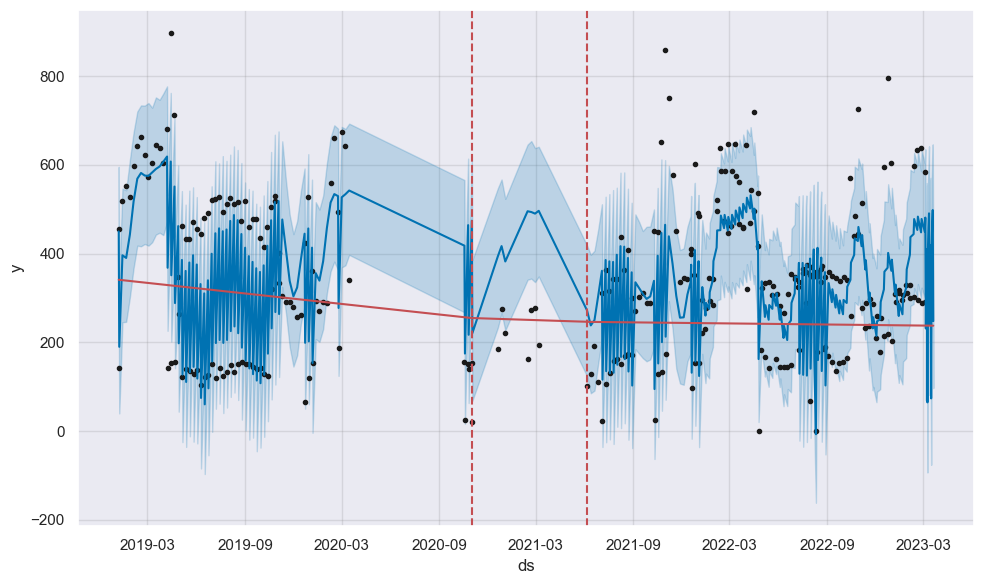

In [112]:

fig = baseline_model.plot(forecast_df)
a = add_changepoints_to_plot(fig.gca(), baseline_model, forecast_df)

In [120]:

# NTE, ORY, PIS, LYS: France 
# FUE, BCN: Espagne
# LGW, LHR: Londres
# AMS: Pays-Bas
# LIS, OPO: Portugal
# PNH: Cambodge
# NGB: Chine
# POP: Dominican Republic
# JFK: NY
# SCL: Chili
# SSA, GRU: Brésil

### Confinement en France, du 17 mars au 11 mai 2020 non inclus, soit 1 mois et 25 jours ;
#                         du 30 octobre au 15 décembre 2020 non inclus, soit 1 mois et 15 jours ;
#                         du 3 avril au 3 mai 2021 non inclus, soit 28 jours.

### Confinement en Espagne, 5 mars 2020 – 21 juin 2020
#                          25/10/ - 09/05/2021

### Confinement in England: 23/03 - 03/06
#                           05/11 -2/12
#                           28/12 - 5/1

#### Confinement in nerthelands: 19/12/2021 -14/01/2022

#### Confinement in portugal: 02/04/2020 - 18/05/2020
                          
#### confinement in cambodia: 28/03/2020 - 11/2021    

#### Confinement in Domicain Republic: 17/03 - 
#                                       26/05 -20/07/2020

### confinement in brazil : 21/03- 07/04/2020
                
#### Confinement in Newyork 12/3 - 15/05/2020  


#### Confinement in Santigo, chili: 26/03/2020 - 16/08/2020
#                    20/03/2021 -30/05/2021

#### Confinement in China: 24/01/2020 - 20/02/2020


### Coronavirus: l’Europe ferme ses frontières ===> avoir une impact sur sur le nombre de vols par jours, et le nombre de passengers 


#by order of home air port and paired airport 
# LGW to (BCN - AMS) 

lockdowns_LGW_BCN = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-05', 'lower_window': 0, 'ds_upper': '2020-06-21'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-25', 'lower_window': 0, 'ds_upper': '2021-05-09'},
])

lockdowns_LGW_AMS = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-23', 'lower_window': 0, 'ds_upper': '2020-06-03'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-05', 'lower_window': 0, 'ds_upper': '2020-12-02'},
    {'holiday': 'lockdown_3', 'ds': '2020-12-28', 'lower_window': 0, 'ds_upper': '2021-01-05'},
    {'holiday': 'lockdown_4', 'ds': '2021-12-19', 'lower_window': 0, 'ds_upper': '2022-01-14'},
])

lockdowns_LIS_ORY = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-17', 'lower_window': 0, 'ds_upper': '2020-05-18'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-30', 'lower_window': 0, 'ds_upper': '2020-12-15'},
    {'holiday': 'lockdown_3', 'ds': '2021-04-03', 'lower_window': 0, 'ds_upper': '2021-05-03'},
])

lockdowns_LIS_OPO = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-04-02', 'lower_window': 0, 'ds_upper': '2020-05-18'},
])

lockdowns_SSA_GRU = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-04-07'},
])

lockdowns_NTE_FUE = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-05', 'lower_window': 0, 'ds_upper': '2020-06-21'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-25', 'lower_window': 0, 'ds_upper': '2021-05-09'},
])

lockdowns_LIS_PIS = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-17', 'lower_window': 0, 'ds_upper': '2020-05-11'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-30', 'lower_window': 0, 'ds_upper': '2020-12-15'},
    {'holiday': 'lockdown_3', 'ds': '2021-04-03', 'lower_window': 0, 'ds_upper': '2021-05-03'},
])

lockdowns_POP_JFK = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-05-15'},
    {'holiday': 'lockdown_2', 'ds': '2020-05-26', 'lower_window': 0, 'ds_upper': '2020-07-20'},
])

lockdowns_SCL_LHA = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-23', 'lower_window': 0, 'ds_upper': '2020-08-16'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-05', 'lower_window': 0, 'ds_upper': '2020-12-02'},
    {'holiday': 'lockdown_3', 'ds': '2020-12-28', 'lower_window': 0, 'ds_upper': '2021-01-05'},
    {'holiday': 'lockdown_4', 'ds': '2021-03-20', 'lower_window': 0, 'ds_upper': '2021-05-30'},
])

# lockdowns = pd.DataFrame([
#     {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
#     {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
#     {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
#     {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
# ])
liste_airport = ["LGW_BCN", "LGW_AMS", "LIS_ORY", "LIS_OPO", "SSA_GRU", "SSA_GRU", "NTE_FUE", "LIS_PIS", "POP_JFK", "SCL_LHA"]
for airport in liste_airport:
    for t_col in ['ds', 'ds_upper']:
        globals()["lockdowns_" + airport][t_col] = pd.to_datetime(globals()["lockdowns_" + airport][t_col])
    globals()["lockdowns_" + airport]['upper_window'] = (globals()["lockdowns_" + airport]['ds_upper'] - globals()["lockdowns_" + airport]['ds']).dt.days


In [122]:
lockdowns_NTE_FUE

holiday         ds  lower_window   ds_upper  upper_window
0  lockdown_1 2020-03-05             0 2020-06-21           108
1  lockdown_2 2020-10-25             0 2021-05-09           196

In [117]:
baseline_model.changepoints

9     2019-03-03
19    2019-04-22
28    2019-05-26
37    2019-06-24
47    2019-07-29
56    2019-09-01
65    2019-09-30
75    2019-11-04
84    2019-12-29
93    2020-02-16
103   2020-11-01
112   2021-06-06
121   2021-07-19
130   2021-08-22
140   2021-10-11
149   2021-11-21
158   2021-12-27
168   2022-01-29
177   2022-02-27
186   2022-04-02
196   2022-05-01
205   2022-06-04
214   2022-07-03
224   2022-07-31
233   2022-08-20
Name: ds, dtype: datetime64[ns]

In [308]:
# Dans cet étape, on va vérifier les changement points dans notre modèle prophet, bien vu que le covid a un impact sur le nombre de passengers, 
# donc que dans ce cas, on va mettre plusieurs changement points dans la périod covid entre 2020 et 2021
# Python
m3_changepoints = (
    # 10 potential changepoints in 2.5 years
    pd.date_range(generate_route_df(traffic_df, 'NTE', "FUE").rename(columns = {'date':'ds', 'pax_total':'y'})["ds"][0], lockdowns_NTE_FUE["ds"][0], periods=10).date.tolist() +
    # 20 potential changepoints in 1 year 2 months
    pd.date_range(lockdowns_NTE_FUE["ds"][0], lockdowns_NTE_FUE["ds"].iloc[-1], periods = 15).date.tolist()
)

In [306]:
# Define funcion with the coefficients to estimate
def func_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

In [309]:
from scipy.optimize import curve_fit

df = generate_route_df(traffic_df, 'NTE', "FUE").rename(columns = {'date':'ds', 'pax_total':'y'})
# Randomly initialize the coefficients
p0 = np.random.exponential(size=3)
# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])
# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(df['ds']) + 1
y = np.array(df['y'])
(a,b,c),cov = curve_fit(func_logistic, x, y, bounds=bounds, p0=p0, maxfev=1000000)
                
# The time step at which the growth is fastest
t_fastest = np.log(a) / b
i_fastest = func_logistic(t_fastest, a, b, c)

In [310]:
df

home_airport paired_airport         ds      y
0            NTE            FUE 2019-01-06  456.0
1            NTE            FUE 2019-01-07  142.0
2            NTE            FUE 2019-01-13  519.0
3            NTE            FUE 2019-01-20  553.0
4            NTE            FUE 2019-01-27  528.0
..           ...            ...        ...    ...
288          NTE            FUE 2023-02-19  296.0
289          NTE            FUE 2023-02-25  638.0
290          NTE            FUE 2023-02-26  289.0
291          NTE            FUE 2023-03-04  584.0
292          NTE            FUE 2023-03-05  290.0

[293 rows x 4 columns]

In [313]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
df.columns = ['home_airport','paired_airport','ds', 'y', 'cap']

my_model = Prophet(holidays = lockdowns_NTE_FUE, changepoints = m3_changepoints, changepoint_prior_scale= 0.05, growth="logistic")
my_model.fit(df)
forecast2 = my_model.predict(future_df)

ValueError: Length mismatch: Expected axis has 4 elements, new values have 5 elements

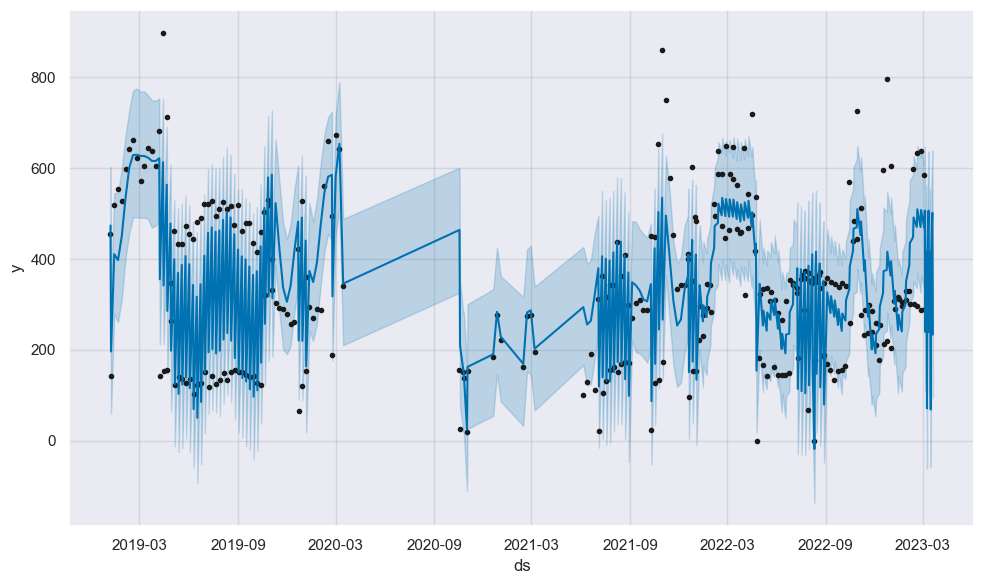

In [291]:
my_model.plot(forecast2);

In [302]:
eval_df = cross_validation(my_model, initial='366 days', period = '90 days' , horizon= '90 days')
eval_df

  0%|          | 0/10 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper      y     cutoff
0   2020-10-18  453.447422  362.668608  542.373864  155.0 2020-09-16
1   2020-10-19  130.976192   45.227342  221.820417   26.0 2020-09-16
2   2020-10-25  495.548912  397.794971  580.646526  152.0 2020-09-16
3   2020-10-26  161.021858   74.146619  252.734179  139.0 2020-09-16
4   2020-11-01  444.290532  352.969703  537.738086   20.0 2020-09-16
..         ...         ...         ...         ...    ...        ...
189 2023-02-19  586.169825  463.604559  713.594734  296.0 2022-12-05
190 2023-02-25  483.601518  362.365225  591.474842  638.0 2022-12-05
191 2023-02-26  579.918471  467.440864  703.313719  289.0 2022-12-05
192 2023-03-04  477.413527  354.030392  592.125733  584.0 2022-12-05
193 2023-03-05  574.557407  466.277446  694.991269  290.0 2022-12-05

[194 rows x 6 columns]

In [304]:
performance_metrics(eval_df)

horizon           mse        rmse         mae     mdape     smape  coverage
0  10 days   5878.982635   76.674524   60.522190  0.180093  0.247905  0.842105
1  11 days   6746.714474   82.138386   64.547826  0.227756  0.278800  0.815789
2  12 days  10653.457396  103.215587   73.409310  0.180093  0.290945  0.789474
3  13 days  11984.416553  109.473360   79.444895  0.233184  0.306069  0.763158
4  14 days  11472.235133  107.108520   76.661337  0.186619  0.298018  0.789474
..     ...           ...         ...         ...       ...       ...       ...
76 86 days  26804.408964  163.720521  131.952520  0.456758  0.497066  0.456140
77 87 days  21406.954078  146.311155  123.803930  0.363124  0.432441  0.473684
78 88 days  18616.237867  136.441335  110.584584  0.323875  0.393092  0.578947
79 89 days  17053.764581  130.590063  102.917783  0.189271  0.359908  0.631579
80 90 days  21128.861483  145.357702  115.438483  0.242004  0.396746  0.578947

[81 rows x 7 columns]

In [230]:
df2 = generate_route_df(traffic_df, 'NTE', "FUE").rename(columns = {'date':'ds', 'pax_total':'y'}).copy()
df2['pre_covid'] = pd.to_datetime(df2['ds']) < generate_route_df(traffic_df, 'NTE', "FUE").rename(columns = {'date':'ds', 'pax_total':'y'})["ds"][0]
df2['post_covid'] = ~df2['pre_covid']

In [243]:
# Python
m4 = Prophet(holidays = lockdowns_NTE_FUE, changepoints = m3_changepoints, weekly_seasonality = False)
# Python
m4.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
m4.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
);

In [244]:
# Python
m4 = m4.fit(df2)
# Python
future4 = m4.make_future_dataframe(periods=15)
future4['pre_covid'] = pd.to_datetime(future4['ds']) < generate_route_df(traffic_df, 'NTE', "FUE").rename(columns = {'date':'ds', 'pax_total':'y'})["ds"][0]
future4['post_covid'] = ~future4['pre_covid']


In [245]:
forecast4 = m4.predict(future4)

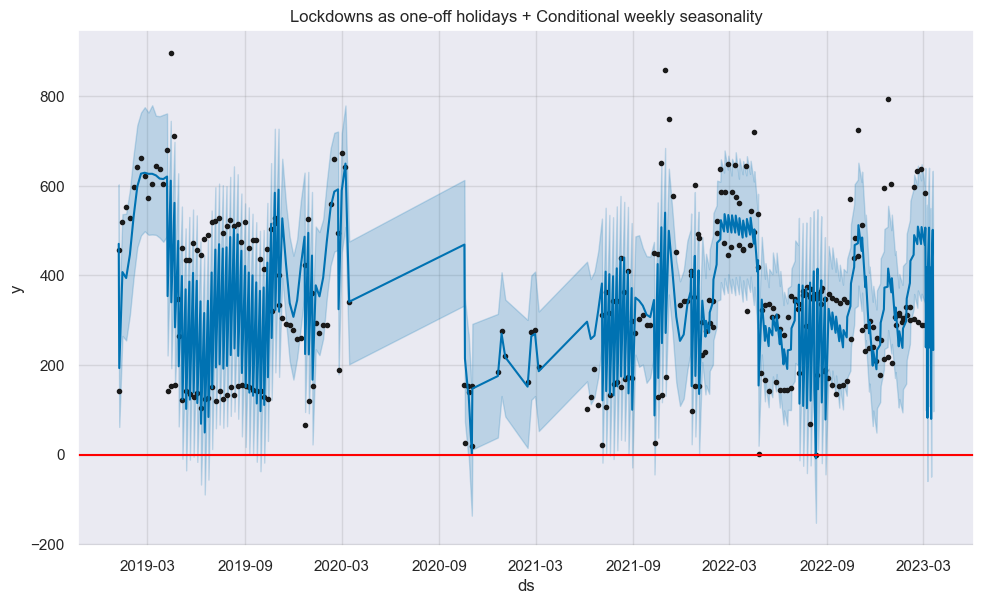

In [247]:
m4.plot(forecast4)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays + Conditional weekly seasonality');

In [248]:
eval4 = cross_validation(m4, initial='366 days', period = '90 days' , horizon= '90 days')
eval4

  0%|          | 0/10 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper      y     cutoff
0   2020-10-18  455.876896  361.788034  535.911645  155.0 2020-09-16
1   2020-10-19  133.464931   42.829060  226.370607   26.0 2020-09-16
2   2020-10-25  498.008718  411.949083  586.796641  152.0 2020-09-16
3   2020-10-26  163.538002   71.356504  251.222343  139.0 2020-09-16
4   2020-11-01  446.761807  363.815258  533.689145   20.0 2020-09-16
..         ...         ...         ...         ...    ...        ...
189 2023-02-19  581.505244  464.827925  699.601003  296.0 2022-12-05
190 2023-02-25  480.300443  359.410892  609.715858  638.0 2022-12-05
191 2023-02-26  575.789064  453.220148  693.870129  289.0 2022-12-05
192 2023-03-04  473.782292  352.630796  600.478423  584.0 2022-12-05
193 2023-03-05  569.944461  448.797057  699.221233  290.0 2022-12-05

[194 rows x 6 columns]

In [249]:
performance_metrics(eval4)

horizon           mse        rmse         mae     mdape     smape  coverage
0  10 days   6095.876336   78.076093   62.040781  0.187801  0.255408  0.789474
1  11 days   6897.410331   83.050649   65.939185  0.213568  0.285995  0.763158
2  12 days  10805.010387  103.947152   73.986048  0.187801  0.295818  0.736842
3  13 days  12048.024496  109.763493   79.721155  0.213568  0.310182  0.710526
4  14 days  11534.202134  107.397403   76.607551  0.187801  0.299728  0.736842
..     ...           ...         ...         ...       ...       ...       ...
76 86 days  26992.567866  164.294150  133.216023  0.425230  0.504096  0.456140
77 87 days  21434.857628  146.406481  124.459091  0.326116  0.438030  0.473684
78 88 days  18798.071160  137.106058  111.797143  0.293345  0.400324  0.578947
79 89 days  17219.043412  131.221353  104.283092  0.206529  0.367302  0.631579
80 90 days  21243.223707  145.750553  117.677640  0.326116  0.419600  0.578947

[81 rows x 7 columns]

#### Automate the model fitting and evaluation (Pour prophet)

In [47]:
routes = (traffic_df
.drop_duplicates(subset= ['home_airport', 'paired_airport'] )
[["home_airport", "paired_airport"]].to_dict(orient= 'rows')
)

/var/folders/q2/tks8t2v53c95y3jqch98mqrc0000gn/T/ipykernel_3326/2408516884.py:1: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



In [51]:
# %%capture
# output = do_some_verbose_things(args)

In [53]:
routes = (traffic_df
.drop_duplicates(subset= ['home_airport', 'paired_airport'] )
[["home_airport", "paired_airport"]].to_dict(orient= 'rows')
)
models = dict()
performances = dict()
for route in routes[:2]:
    print(route)
    home = route['home_airport']
    paired = route['paired_airport']
    #build route traffic dataFrame
    _df = generate_route_df(traffic_df, home, paired)
    # Create a model
    _model = Prophet()
    #fit 
    _model.fit(_df.rename(columns={'date': 'ds', 'pax_total': 'y'}))
    # and evaluation the model
    _cv_df = cross_validation(_model, horizon= '30 days')
    _perf_df = performance_metrics(_cv_df, rolling_window= 1)
    #save the model to a dictionary
    models[(route['home_airport'], route['paired_airport'])] = _model
    performances[(route['home_airport'], route['paired_airport'])] = _perf_df['rmse'].values[0]


/var/folders/q2/tks8t2v53c95y3jqch98mqrc0000gn/T/ipykernel_3326/1288369371.py:1: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



{'home_airport': 'LGW', 'paired_airport': 'BCN'}


  0%|          | 0/147 [00:00<?, ?it/s]

{'home_airport': 'LGW', 'paired_airport': 'AMS'}


  0%|          | 0/137 [00:00<?, ?it/s]

In [54]:
routes = (traffic_df
.drop_duplicates(subset= ['home_airport', 'paired_airport'] )
[["home_airport", "paired_airport"]].to_dict(orient= 'rows')
)
models = dict()
performances = dict()
for route in routes:
    print(route)
    home = route['home_airport']
    paired = route['paired_airport']
    #build route traffic dataFrame
    _df = generate_route_df(traffic_df, home, paired)
    # Create a model
    _model = Prophet()
    #fit 
    _model.fit(_df.rename(columns={'date': 'ds', 'pax_total': 'y'}))
    # and evaluation the model
    _cv_df = cross_validation(_model, horizon= '30 days', parallel = "processes")
    _perf_df = performance_metrics(_cv_df, rolling_window= 1)
    #save the model to a dictionary
    models[(route['home_airport'], route['paired_airport'])] = _model
    performances[(route['home_airport'], route['paired_airport'])] = _perf_df['rmse'].values[0]

/var/folders/q2/tks8t2v53c95y3jqch98mqrc0000gn/T/ipykernel_3326/1170065830.py:1: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



{'home_airport': 'LGW', 'paired_airport': 'BCN'}


21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1]

{'home_airport': 'LGW', 'paired_airport': 'AMS'}


21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1

{'home_airport': 'LIS', 'paired_airport': 'ORY'}


21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] done processing
21:31:19 - cmdstanpy - INFO - Chain [1] done processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] done processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] done processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:20 - cmdstanpy - INFO - Chain [1] done processing
21:31:20 - cmdstanpy - INFO - Chain [1] start processing
21:31:20 - cmdstanpy - INFO - Chain [1] done processing
21:31:20 - cmdstanpy - INFO - Chain [1] done processing
21:31:20 - cmdstanpy - INFO - Chain [1] start processing
21:31:20 - cmdstanpy - INFO - Chain [1

{'home_airport': 'LIS', 'paired_airport': 'OPO'}


21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [

{'home_airport': 'SSA', 'paired_airport': 'GRU'}


21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [

{'home_airport': 'NTE', 'paired_airport': 'FUE'}


21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] done processing
21:32:00 - cmdstanpy - INFO - Chain [1] done processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:01 - cmdstanpy - INFO - Chain [1] done processing
21:32:01 - cmdstanpy - INFO - Chain [1] start processing
21:32:01 - cmdstanpy - INFO - Chain [1] done processing
21:32:01 - cmdstanpy - INFO - Chain [1] done processing
21:32:01 - cmdstanpy - INFO - Chain [1] done processing
21:32:01 - cmdstanpy - INFO - Chain [1] start processing
21:32:01 - cmdstanpy - INFO - Chain [

{'home_airport': 'LYS', 'paired_airport': 'PIS'}


21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:05 - cmdstanpy - INFO - Chain [1] start processing
21:32:05 - cmdstanpy - INFO - Chain [1] start processing
21:32:05 - cmdstanpy - INFO - Chain [1] start processing
21:32:05 - cmdstanpy - INFO - Chain [1] done processing
21:32:05 - cmdstanpy - INFO - Chain [1] start processing
21:32:07 - cmdstanpy - INFO - Chain [1] done processing
21:32:07 - cmdstanpy - INFO - Chain [1] done processing
21:32:07 - cmdstanpy - INFO - Chain [1] start processing
21:32:07 - cmdstanpy - INFO - Chain [1] done processing
21:32:07 - cmdstanpy - INFO - Chain [1] start processing
21:32:07 - cmdstanpy - INFO - Chain [1] start processing
21:32:07 - cmdstanpy - INFO - Chain [1] done processing
21:32:07 - cmdstanpy - INFO - Chain 

{'home_airport': 'PNH', 'paired_airport': 'NGB'}


21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain [1] done processing
21:32:31 - cmdstanpy - INFO - Chain [1] done processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain 

{'home_airport': 'POP', 'paired_airport': 'JFK'}


21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [

{'home_airport': 'SCL', 'paired_airport': 'LHR'}


21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:48 - cmdstanpy - INFO - Chain [1] done processing
21:32:48 - cmdstanpy - INFO - Chain [1] start processing
21:32:48 - cmdstanpy - INFO - Chain [1

In [55]:
models

{('LGW', 'BCN'): <prophet.forecaster.Prophet at 0x7fc280a7cca0>,
 ('LGW', 'AMS'): <prophet.forecaster.Prophet at 0x7fc2b663f880>,
 ('LIS', 'ORY'): <prophet.forecaster.Prophet at 0x7fc2a78b91f0>,
 ('LIS', 'OPO'): <prophet.forecaster.Prophet at 0x7fc280219dc0>,
 ('SSA', 'GRU'): <prophet.forecaster.Prophet at 0x7fc280219520>,
 ('NTE', 'FUE'): <prophet.forecaster.Prophet at 0x7fc280a7b5e0>,
 ('LYS', 'PIS'): <prophet.forecaster.Prophet at 0x7fc288012ac0>,
 ('PNH', 'NGB'): <prophet.forecaster.Prophet at 0x7fc280219880>,
 ('POP', 'JFK'): <prophet.forecaster.Prophet at 0x7fc28880c370>,
 ('SCL', 'LHR'): <prophet.forecaster.Prophet at 0x7fc2d445ee50>}

In [56]:
performances

{('LGW', 'BCN'): 1019.1954097881318,
 ('LGW', 'AMS'): 747.826798529831,
 ('LIS', 'ORY'): 718.4211284613352,
 ('LIS', 'OPO'): 484.53754253063454,
 ('SSA', 'GRU'): 1384.5472814195223,
 ('NTE', 'FUE'): 165.81012310104074,
 ('LYS', 'PIS'): 519.4399056992781,
 ('PNH', 'NGB'): 1827.209890884584,
 ('POP', 'JFK'): 63.417292397609565,
 ('SCL', 'LHR'): 104.1813066505356}

In [90]:
for model in models:
    _filename = 'route_model_prophet_{home}_{paired}.json'.format(home = model[0], paired = model[1])
    with open("_filename", "w") as f:
        f.write(model_to_json(models[model]))

In [91]:
reload_models = dict()
for route in routes:
    _filename = 'route_model_prophet_{home}_{paired}.json'.format(home = route['home_airport'], paired = route["paired_airport"])
    with open("_filename", 'r') as f:
        reload_models[(route['home_airport'], route["paired_airport"])] = model_from_json(f.read())

/opt/anaconda3/envs/airtraffic/lib/python3.9/site-packages/prophet/serialize.py:160: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')

/opt/anaconda3/envs/airtraffic/lib/python3.9/site-packages/prophet/serialize.py:160: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')

/opt/anaconda3/envs/airtraffic/lib/python3.9/site-packages/prophet/serialize.py:160: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC tim

In [92]:
reload_models

{('LGW', 'BCN'): <prophet.forecaster.Prophet at 0x7fc2c3a2c190>,
 ('LGW', 'AMS'): <prophet.forecaster.Prophet at 0x7fc2c3753670>,
 ('LIS', 'ORY'): <prophet.forecaster.Prophet at 0x7fc2d2af87c0>,
 ('LIS', 'OPO'): <prophet.forecaster.Prophet at 0x7fc2d3a2af40>,
 ('SSA', 'GRU'): <prophet.forecaster.Prophet at 0x7fc2d3a2aca0>,
 ('NTE', 'FUE'): <prophet.forecaster.Prophet at 0x7fc2c3677370>,
 ('LYS', 'PIS'): <prophet.forecaster.Prophet at 0x7fc289c4fd60>,
 ('PNH', 'NGB'): <prophet.forecaster.Prophet at 0x7fc289c688e0>,
 ('POP', 'JFK'): <prophet.forecaster.Prophet at 0x7fc2d39978e0>,
 ('SCL', 'LHR'): <prophet.forecaster.Prophet at 0x7fc289c29460>}

In [93]:
reload_models = dict()
for model in models:
    _filename = 'route_model_prophet_{home}_{paired}.json'.format(home = model[0], paired = model[1])
    dump(models[model], _filename)
    

In [94]:
for model in models:
    _filename = 'route_model_prophet_{home}_{paired}.json'.format(home = model[0], paired = model[1])
    reload_models[(route['home_airport'], route["paired_airport"])] =  load(_filename)

### Nixtla 

In [97]:
models = [
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]



@njit
def rolling_mean_28(x):
    return rolling_mean(x, window_size=28)


fcst = MLForecast(
    models=models,
    freq='D',
    lags=[7, 14, 21, 28],
    lag_transforms={
        1: [expanding_mean],
        7: [rolling_mean_28]
    },
    date_features=['dayofweek'],
    differences=[1],
)


In [98]:
nixtla_model = fcst.fit(generate_route_df(traffic_df, 'NTE', 'FUE').drop(columns = ['paired_airport']),id_col = 'home_airport', time_col= 'date', target_col= 'pax_total')

In [99]:
predict_df = nixtla_model.predict(14)
predict_df

home_airport       date  LGBMRegressor  XGBRegressor  RandomForestRegressor
0           NTE 2023-03-06     225.004578    240.563339                 168.33
1           NTE 2023-03-07     153.081434     69.187576                  -6.89
2           NTE 2023-03-08     203.201424     10.747890                 -70.19
3           NTE 2023-03-09     147.783229     79.026642                 -46.67
4           NTE 2023-03-10     119.458284    174.058075                  66.40
5           NTE 2023-03-11     152.527471    137.218658                 101.43
6           NTE 2023-03-12     184.736206    156.592697                 140.34
7           NTE 2023-03-13     199.381775     77.995232                  72.17
8           NTE 2023-03-14     111.636944   -137.341553                 -26.10
9           NTE 2023-03-15     418.200058   -210.858246                 -97.45
10          NTE 2023-03-16     305.818732   -204.258087                 -60.82
11          NTE 2023-03-17     339.055006   -115.430923                 -33.81
12          NTE 2023-03-18     277.485552      6.299873                  47.03
13          NTE 2023-03-19     331.545880     94.195770                 103.76

''

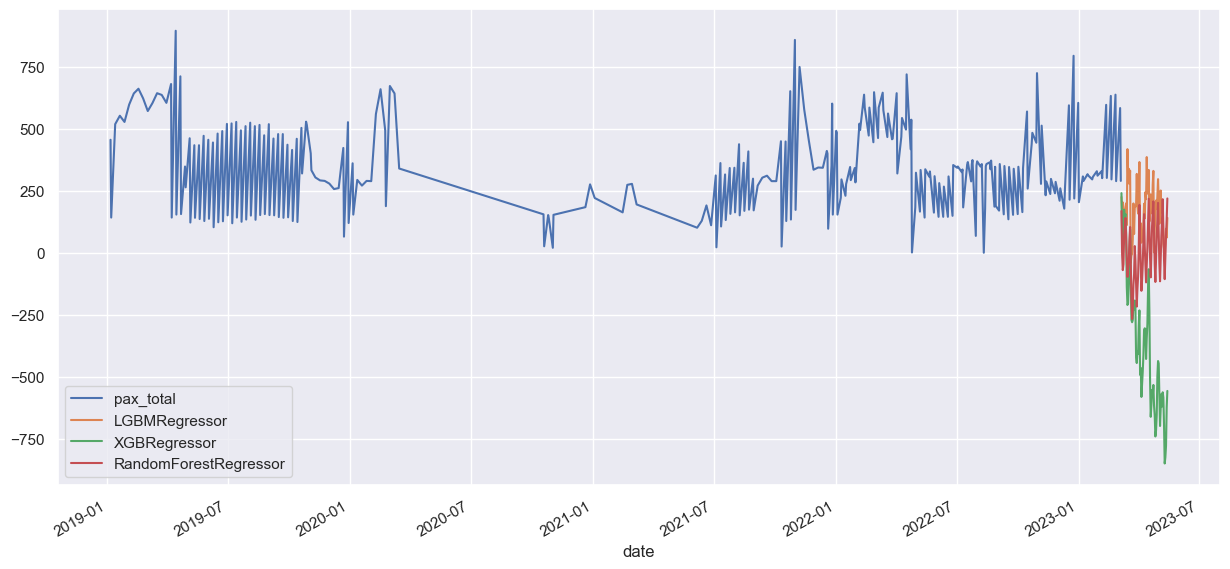

In [100]:
(pd.concat([generate_route_df(traffic_df, 'NTE', 'FUE').drop(columns = ['paired_airport']), nixtla_model.predict(7 * 10)])
.set_index('date')
).plot(figsize= (15,7))
;

In [101]:
draw_ts_multiple((pd.concat([generate_route_df(traffic_df, 'LGW', 'AMS').drop(columns = ['paired_airport']), nixtla_model.predict(7 * 10)])),
                v1 = 'pax_total', v2 = 'LGBMRegressor');

In [102]:
crossvalidation_df = fcst.cross_validation(
    data=generate_route_df(traffic_df, "LGW", "AMS").drop(columns=['paired_airport']),
    window_size=90,
    n_windows=5,
    id_col='home_airport',
    time_col='date',
    target_col='pax_total'
)

/opt/anaconda3/envs/airtraffic/lib/python3.9/site-packages/mlforecast/forecast.py:548: UserWarning:

Excuting `cross_validation` after `fit` can produce unexpected errors



In [103]:
import numpy as np

def mse(y, y_hat):
  delta_y = np.square(y - y_hat)
  return np.nanmean(delta_y)

def rmse(y, y_hat):
  delta_y = np.square(y - y_hat)
  return np.sqrt(mse(y, y_hat))

cv_rmse = crossvalidation_df.groupby(['home_airport', 'cutoff']).apply(lambda df: rmse(df['pax_total'], df['LGBMRegressor'])).mean()
print("RMSE using cross-validation: ", cv_rmse)

cv_rmse = crossvalidation_df.groupby(['home_airport', 'cutoff']).apply(lambda df: rmse(df['pax_total'], df['RandomForestRegressor'])).mean()
print("RMSE using cross-validation: ", cv_rmse)

cv_rmse = crossvalidation_df.groupby(['home_airport', 'cutoff']).apply(lambda df: rmse(df['pax_total'], df['XGBRegressor'])).mean()
print("RMSE using cross-validation: ", cv_rmse)

cv_rmse = (crossvalidation_df
           .assign(Ensemble=lambda _df: _df[['LGBMRegressor', 'RandomForestRegressor', 'XGBRegressor']].mean(axis=1))
           .groupby(['home_airport', 'cutoff']).apply(lambda df: rmse(df['pax_total'], df['Ensemble'])).mean())
print("Ensemble RMSE using cross-validation: ", cv_rmse)

RMSE using cross-validation:  1123.0405776208863
RMSE using cross-validation:  1013.2061289311698
RMSE using cross-validation:  1220.3735710301205
Ensemble RMSE using cross-validation:  1047.6225207933953


### Model Neural forecast

In [104]:


# from neuralforecast import NeuralForecast
# from neuralforecast.models import NBEATS, NHITS

# horizon = 90
# models = [NBEATS(input_size=2 * horizon, h=horizon, max_epochs=50),
#           NHITS(input_size=2 * horizon, h=horizon, max_epochs=50)]

# nforecast = NeuralForecast(models=models, freq='D')
# nforecast.fit(df=generate_route_df(traffic_df, "LGW", "AMS").drop(columns=['paired_airport']).rename(columns={'home_airport': 'unique_id',
#                                                                                                       'date': 'ds',
#                                                                                                       'pax_total': 'y'}))